In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(10136, 2048)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(10136, 2048)

In [10]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [11]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 22.5min


[CV] .............. C=0.01, gamma=1e-08, score=0.138889, total=13.6min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137795, total=13.6min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.139442, total=13.6min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137795, total=13.6min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137695, total=13.6min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138477, total=13.7min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.137795, total=13.8min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 25.0min


[CV] .............. C=0.01, gamma=1e-07, score=0.137695, total=15.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.137795, total=15.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.136986, total=15.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.137695, total=15.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.138751, total=15.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137255, total=15.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.139165, total=15.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 25.3min


[CV] .............. C=0.01, gamma=1e-06, score=0.137795, total=13.5min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138477, total=13.6min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138751, total=13.6min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.139165, total=13.6min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138889, total=13.6min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.139442, total=13.7min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.137695, total=13.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 50.6min


[CV] .............. C=0.01, gamma=1e-05, score=0.139442, total=15.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.138751, total=15.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.139165, total=15.7min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.136986, total=15.8min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.137255, total=15.8min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.137695, total=15.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.137795, total=15.8min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 65.6min


[CV] .............. C=0.01, gamma=0.001, score=0.411133, total=12.4min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.416339, total=12.3min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.412402, total=12.3min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.420376, total=12.3min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.423191, total=12.3min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.424603, total=12.3min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.424453, total=12.3min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 73.4min


[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............... C=0.01, gamma=0.01, score=0.441147, total=14.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............... C=0.01, gamma=0.01, score=0.464286, total=14.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.463221, total=14.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.459861, total=14.1min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.443227, total=14.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.371094, total=19.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.346380, total=19.1min
[CV] C

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 91.5min


[CV] ................ C=0.01, gamma=1.0, score=0.214844, total=18.9min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.203523, total=18.8min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.191176, total=18.8min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.214567, total=18.8min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.216535, total=21.1min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.211672, total=21.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.217047, total=21.0min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 113.6min


[CV] ............... C=0.1, gamma=1e-08, score=0.136986, total=13.4min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.137255, total=13.6min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.137795, total=13.5min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.137795, total=13.5min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.138477, total=13.6min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.138751, total=13.4min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.138889, total=13.6min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 130.2min


[CV] ............... C=0.1, gamma=1e-07, score=0.138477, total=15.5min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.137795, total=15.5min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138751, total=15.5min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138889, total=15.5min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.137695, total=13.9min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.136986, total=13.8min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.137255, total=13.8min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 151.4min


[CV] ............... C=0.1, gamma=0.001, score=0.826810, total= 5.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.797244, total= 5.3min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.794118, total= 5.3min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.453125, total=12.9min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.457926, total=13.0min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=0.001, score=0.829871, total= 5.3min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=0.001, score=0.809055, total= 5.4min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 156.6min


[CV] .............. C=0.1, gamma=0.0001, score=0.459245, total=11.2min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.456175, total=11.1min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.456888, total=12.9min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.461310, total=12.9min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.823588, total= 5.2min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.808532, total= 5.2min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.823062, total= 5.3min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 181.4min


[CV] ................. C=0.1, gamma=0.1, score=0.453125, total=17.4min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.451961, total=17.4min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.437992, total=17.4min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.440945, total=17.3min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.440158, total=17.3min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.471173, total=17.4min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.450199, total=17.3min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 200.6min


[CV] ................ C=0.1, gamma=10.0, score=0.251969, total=18.5min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.266073, total=18.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.137695, total=15.3min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.136986, total=15.3min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.137795, total=15.3min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.137255, total=15.4min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.137795, total=13.3min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 226.7min


[CV] ............... C=1.0, gamma=1e-07, score=0.138889, total=15.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.139165, total=13.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.139442, total=13.6min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.460784, total=11.2min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.467520, total=11.3min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.137795, total=14.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.137695, total=15.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 239.3min


[CV] .............. C=1.0, gamma=0.0001, score=0.798039, total= 4.9min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.799213, total= 4.8min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.901367, total= 2.4min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.906863, total= 2.5min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.923679, total= 2.5min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.929773, total= 2.5min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.898622, total= 2.9min
[CV] C=1.0, gamma=0.1 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 250.6min


[CV] ................ C=1.0, gamma=0.01, score=0.934718, total= 6.0min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.933598, total= 6.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.924603, total= 6.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.932406, total= 6.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.938247, total= 6.1min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.595472, total=14.4min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.603922, total=14.5min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 277.5min


[CV] ................. C=1.0, gamma=1.0, score=0.371063, total=19.9min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.375865, total=19.9min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.400794, total=20.0min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.384539, total=20.1min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.315945, total=18.1min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.324431, total=18.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.333003, total=18.2min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 305.4min


[CV] .............. C=10.0, gamma=1e-07, score=0.138751, total=16.1min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.459961, total=10.9min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.462818, total=11.0min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.813477, total= 4.8min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.460784, total=11.1min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.797059, total= 4.8min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.796260, total= 4.9min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 316.4min


[CV] .............. C=10.0, gamma=0.001, score=0.949219, total= 1.9min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.924453, total= 2.3min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.965753, total= 1.9min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.464215, total=11.0min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.912351, total= 2.3min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.829026, total= 5.5min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.461155, total=11.1min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 338.0min


[CV] ................ C=10.0, gamma=0.1, score=0.625984, total=14.9min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=0.1, score=0.615157, total=16.9min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=0.1, score=0.634026, total=17.0min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=0.1, score=0.626363, total=16.9min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.631944, total=16.9min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.662028, total=17.0min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.640438, total=16.9min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 368.4min


[CV] ............. C=100.0, gamma=1e-07, score=0.459961, total=11.1min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.460784, total=11.1min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.462818, total=11.2min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.468504, total=11.3min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.358847, total=21.6min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.341633, total=21.6min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.457677, total=11.2min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 381.1min


[CV] ............. C=100.0, gamma=1e-05, score=0.926660, total= 2.7min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.912698, total= 2.7min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.820614, total= 4.9min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.808532, total= 4.9min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.829026, total= 4.9min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.913347, total= 2.7min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.815737, total= 4.9min
[CV] C=100.0, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 392.9min


[CV] .............. C=100.0, gamma=0.01, score=0.944882, total= 6.0min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.932607, total= 6.0min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.932540, total= 6.1min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.940196, total= 7.1min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.934394, total= 6.1min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.948207, total= 7.0min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............... C=100.0, gamma=0.1, score=0.629159, total=14.4min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 428.9min


[CV] ............ C=1000.0, gamma=1e-07, score=0.796260, total= 4.9min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.812008, total= 4.9min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.828882, total= 4.9min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.457677, total=10.9min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.321850, total=18.3min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.459961, total=12.7min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.336301, total=18.4min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 439.5min


[CV] ............ C=1000.0, gamma=1e-07, score=0.815737, total= 4.9min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.930118, total= 1.7min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.358847, total=21.5min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.341633, total=21.5min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.946322, total= 1.8min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.943898, total= 1.8min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.939484, total= 1.7min
[CV] C=1000.0, gamma=0.01 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 484.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
top_model.cv_results_

{'mean_fit_time': array([  801.62255678,   819.90335569,   759.84895663,   814.51706507,
          864.9627835 ,   686.31668711,   784.10241313,   977.06022329,
         1148.8548022 ,  1165.55114472,   775.5556922 ,   862.5470592 ,
          767.90860028,   867.16312521,   658.2008215 ,   279.59252119,
          397.52337799,   965.97330992,  1060.54273038,  1158.44425838,
          786.51233513,   804.07168863,   846.12233391,   658.5038614 ,
          269.49334331,   133.48660715,   354.54009168,   872.61310296,
         1112.039553  ,  1039.14856951,   848.05099053,   818.11324062,
          649.46168308,   276.73580341,   118.63947926,   107.13681188,
          353.98671792,   921.05509262,  1102.18988872,  1132.44056678,
          866.52483587,   634.66467788,   269.39484503,   126.09107122,
           92.89896023,   107.35919802,   350.01746235,   917.74764247,
         1075.25737007,  1143.95042913,   676.29561517,   263.53319285,
          121.8452915 ,    88.08298779,    91.5

In [13]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.41900, std: 0.00474, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.45107, std: 0.00836, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.35270, std: 0.01051, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.21152, std: 0.00780, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.17620, std: 0.00432, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [14]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 100.0, 'gamma': 0.001} - score: 0.9514


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


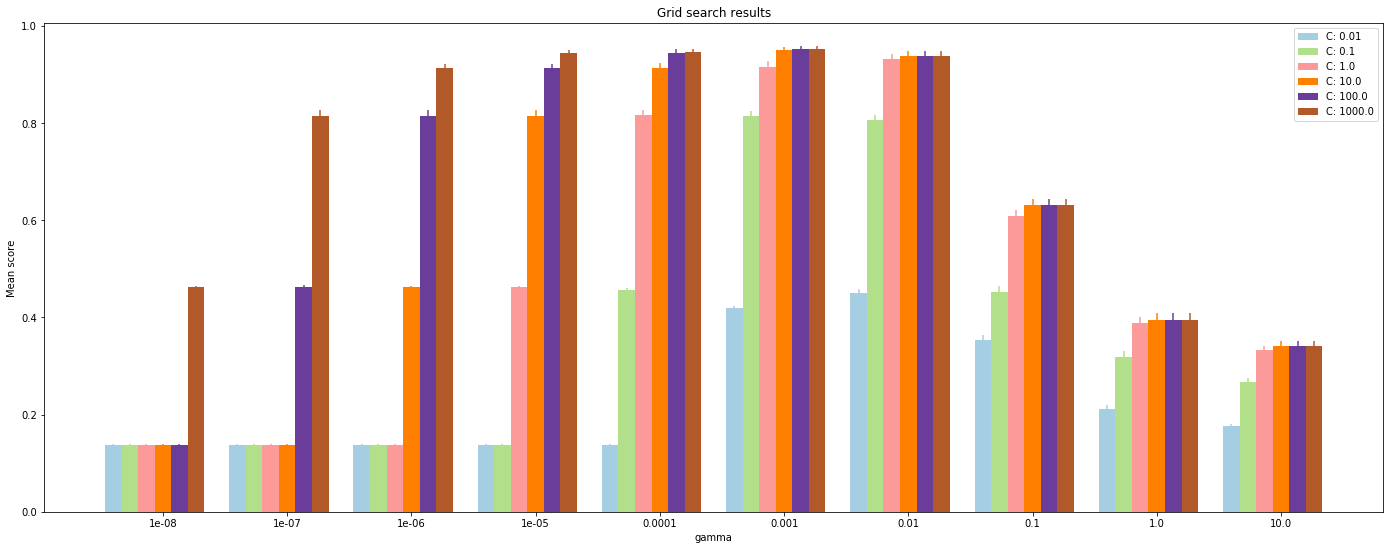

In [15]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()